In [1]:
from collections import defaultdict
import os
from pathlib import Path
import sys
from typing import Any

import dill
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import bootstrap
import seaborn as sns
from tqdm.auto import tqdm

import src.fact_reasoner
from src.fact_reasoner.comprehensiveness import ComprehensivenessResult

sys.modules["fm_factual"] = src.fact_reasoner


def load_results(filename: str) -> tuple[dict, list[list[ComprehensivenessResult]]]:
    """Loads experiment arguments and results from a dill file.

    Args:
        filename: str
            The name of the dill file to load (should be located in RESULTS_PATH).

    Returns:
        tuple[dict, list[list[ComprehensivenessResult]]]:
            A tuple containing the experiment arguments and the list of results.
            Results in the inner list share the same contexts, but differ in the
            evaluated answers.
    """
    load_dotenv()
    RESULTS_PATH = os.environ["RESULTS_PATH"]

    save_file_path = f"{RESULTS_PATH}/{filename}"
    if not os.path.exists(save_file_path):
        raise FileNotFoundError(f"File {save_file_path} doesn't exist!")
    with open(save_file_path, "rb") as f:
        experiment_data = dill.load(f)

    return experiment_data["args"], experiment_data["results"]


def get_scores(
    all_results: list[list[ComprehensivenessResult]], score_key: str
) -> np.ndarray:
    """Extracts scores from a list of ComprehensivenessResult objects.

    Args:
        all_results: list[list[ComprehensivenessResult]]
            A list of lists of ComprehensivenessResult objects. Each inner list
            contains results for the same contexts but different answers.
        score_key: str
            The key of the score to extract from each ComprehensivenessResult.

    Returns:
        np.ndarray:
            An array of mean scores for each group of results with the same contexts.
    """
    group_means = [
        np.mean(
            [result["comprehensiveness_eval_results"][score_key] for result in results]  # type: ignore
        )
        for results in all_results
    ]
    return np.array(group_means)

# Meta-Evaluation


In [2]:
def calculate_mean_statistic(wc_scores, cb_scores, axis=-1) -> np.ndarray:
    """Calculates the mean statistic given evaluation results.

    Args:
        wc_scores: np.ndarray
            An array of WikiContradict scores.
        cb_scores: np.ndarray
            An array of Comprehensiveness mean scores.
        axis: int, optional
            The axis along which to compute the means. Default is -1.

    Returns:
        np.ndarray:
            An array containing the following statistics in order:
            [WikiContradict Mean, Comprehensiveness Mean, Overall Mean]
    """
    wc_mean = np.mean(wc_scores, axis=axis)
    cb_mean = np.mean(cb_scores, axis=axis)
    overall_mean = (wc_mean + cb_mean) / 2.0

    return overall_mean


def calculate_all_statistics(wc_scores, cb_lax, cb_str, axis=-1) -> np.ndarray:
    """Calculates all the mean statistics given evaluation results.

    Args:
        wc_scores: np.ndarray
            An array of WikiContradict scores.
        cb_lax: np.ndarray
            An array of Comprehensiveness Lax scores.
        cb_str: np.ndarray
            An array of Comprehensiveness Strict scores.
        axis: int, optional
            The axis along which to compute the means. Default is -1.

    Returns:
        np.ndarray:
            An array containing the following statistics in order:
            [WikiContradict Mean, Comprehensiveness Lax Mean,
             Comprehensiveness Moderate Mean, Comprehensiveness Strict Mean,
             Comprehensiveness Mean, Overall Mean]
    """
    wc_mean = np.mean(wc_scores, axis=axis)
    cb_lax_mean = np.mean(cb_lax, axis=axis)
    cb_str_mean = np.mean(cb_str, axis=axis)

    cb_mean = (cb_lax_mean + cb_str_mean) / 2.0
    overall_mean = (wc_mean + cb_mean) / 2.0

    return np.array([wc_mean, cb_lax_mean, cb_str_mean, cb_mean, overall_mean])

In [3]:
EXPERIMENT_VERSION = "v12"
load_dotenv()
RESULTS_PATH = os.environ["RESULTS_PATH"]

# Results on different datasets with the same configuration are grouped together
grouped_files = defaultdict(list)
for p in Path(RESULTS_PATH).iterdir():
    if p.is_file() and f"_{EXPERIMENT_VERSION}_" in p.name:
        args, _ = load_results(p.name)
        config_key = (
            args["model_name"],
            args["variant"],
            args["relevance_threshold"],
            args["confidence_threshold"],
            not args["disable_tools"],
        )
        grouped_files[config_key].append(p.name)

analysis_results = []

for config_key, filenames in (progress := tqdm(grouped_files.items())):
    progress.set_description(f"Processing config: {config_key}")
    wc_results_file = next(
        (f for f in filenames if "wiki_contradict_humaneval" in f), None
    )
    cb_results_file = next((f for f in filenames if "conflict_bank" in f), None)

    if not wc_results_file or not cb_results_file:
        raise ValueError(f"Missing required result files for config {config_key}!")

    _, wc_all_results = load_results(wc_results_file)
    _, cb_all_results = load_results(cb_results_file)

    # We aggregate results for the same contexts in get_scores before bootstrapping,
    # as they are not independent.
    wc_scores = get_scores(wc_all_results, "score_satisfies_criteria")
    cb_lax_scores = get_scores(cb_all_results, "lax_score")
    cb_strict_scores = get_scores(cb_all_results, "strict_score")
    cb_mean_scores = (cb_lax_scores + cb_strict_scores) / 2.0

    stats = {
        "WikiContradict Base": {"scores": (wc_scores,), "statistic": np.mean},
        "ConflictBank Lax": {"scores": (cb_lax_scores,), "statistic": np.mean},
        "ConflictBank Strict": {"scores": (cb_strict_scores,), "statistic": np.mean},
        "ConflictBank Mean": {"scores": (cb_mean_scores,), "statistic": np.mean},
        "Mean": {
            "scores": (wc_scores, cb_mean_scores),
            "statistic": calculate_mean_statistic,
        },
    }

    bootstrap_results = {}
    for stat_name, stat_info in stats.items():
        scores = stat_info["scores"]
        statistic = stat_info["statistic"]
        res = bootstrap(
            scores,
            statistic,
            paired=False,
            n_resamples=10000,
            method="bca",
            rng=42,
            confidence_level=0.95,
        )
        bootstrap_results[stat_name] = res

    point_estimates = calculate_all_statistics(
        wc_scores, cb_lax_scores, cb_strict_scores
    )

    def create_row(name: str, value: float):
        return {
            "model": config_key[0],
            "variant": config_key[1],
            "relevance_threshold": config_key[2],
            "confidence_threshold": config_key[3],
            "use_tools": config_key[4],
            "result": name,
            "value": value,
        }

    for (name, bootstrap_res), point_estimate in zip(
        bootstrap_results.items(), point_estimates, strict=True
    ):
        analysis_results.append(create_row(f"{name} (Mean)", point_estimate))
        analysis_results.append(
            create_row(f"{name} (CI Low)", bootstrap_res.confidence_interval.low)
        )
        analysis_results.append(
            create_row(f"{name} (CI High)", bootstrap_res.confidence_interval.high)
        )

df = pd.DataFrame(analysis_results)
df = (
    df.pivot(
        index=[
            "model",
            "variant",
            "relevance_threshold",
            "confidence_threshold",
            "use_tools",
        ],
        columns="result",
        values="value",
    )
    .reset_index()
    .sort_values(by=["model", "variant"], key=lambda col: col.str.lower())
)
df = df.reset_index(drop=True)

df

  0%|          | 0/18 [00:00<?, ?it/s]

result,model,variant,relevance_threshold,confidence_threshold,use_tools,ConflictBank Lax (CI High),ConflictBank Lax (CI Low),ConflictBank Lax (Mean),ConflictBank Mean (CI High),ConflictBank Mean (CI Low),ConflictBank Mean (Mean),ConflictBank Strict (CI High),ConflictBank Strict (CI Low),ConflictBank Strict (Mean),Mean (CI High),Mean (CI Low),Mean (Mean),WikiContradict Base (CI High),WikiContradict Base (CI Low),WikiContradict Base (Mean)
0,gpt-oss-120b,e2e,3.5,2.0,False,0.764667,0.721000,0.743000,0.700708,0.671283,0.686417,0.642917,0.616102,0.629833,0.737750,0.703298,0.721125,0.786667,0.724167,0.755833
1,gpt-oss-120b,nli,3.5,2.0,False,0.688167,0.638970,0.664000,0.664292,0.632125,0.648125,0.644741,0.620667,0.632250,0.643834,0.605937,0.625312,0.635000,0.565833,0.602500
2,gpt-oss-120b,qa,3.5,2.0,False,0.962167,0.935833,0.950500,0.828958,0.805083,0.817292,0.701000,0.667917,0.684083,0.798000,0.762396,0.780729,0.775833,0.710833,0.744167
3,gpt-oss-20b,e2e,3.5,2.0,False,0.920833,0.893500,0.907500,0.778542,0.757875,0.768375,0.643000,0.615833,0.629250,0.792562,0.761979,0.777937,0.815000,0.757500,0.787500
4,gpt-oss-20b,nli,3.5,2.0,False,0.688000,0.639333,0.663833,0.686458,0.653583,0.669958,0.688167,0.664250,0.676083,0.612771,0.570570,0.592062,0.552500,0.474167,0.514167
5,gpt-oss-20b,qa,3.5,2.0,False,0.945500,0.915500,0.932333,0.872178,0.845042,0.859500,0.803650,0.768583,0.786667,0.819906,0.783636,0.802250,0.777500,0.710833,0.745000
6,llama-3.3-70b-instruct,e2e,3.5,2.0,False,0.986667,0.977000,0.982333,0.825500,0.814333,0.819958,0.667500,0.648333,0.657583,0.829646,0.802521,0.817062,0.839167,0.785833,0.814167
7,llama-3.3-70b-instruct,nli,3.5,2.0,True,0.903000,0.872833,0.888500,0.732542,0.707292,0.720375,0.566583,0.537917,0.552250,0.656795,0.614044,0.635604,0.591667,0.510000,0.550833
8,llama-3.3-70b-instruct,qa,3.5,2.0,False,0.978667,0.959667,0.970333,0.810667,0.788458,0.800000,0.646783,0.612000,0.629667,0.773750,0.735937,0.755833,0.745833,0.674167,0.711667
9,llama-3.3-70b-instruct,qa,3.5,2.0,True,0.983667,0.966667,0.976667,0.821875,0.801269,0.811792,0.663856,0.630417,0.646917,0.782392,0.747173,0.765479,0.751667,0.685000,0.719167


In [10]:
df[
    [
        "model",
        "variant",
        "use_tools",
        "Mean (Mean)",
        "Mean (CI Low)",
        "Mean (CI High)",
    ]
]

result,model,variant,use_tools,Mean (Mean),Mean (CI Low),Mean (CI High)
0,gpt-oss-120b,e2e,False,0.721125,0.703298,0.737750
1,gpt-oss-120b,nli,False,0.625312,0.605937,0.643834
2,gpt-oss-120b,qa,False,0.780729,0.762396,0.798000
3,gpt-oss-20b,e2e,False,0.777937,0.761979,0.792562
4,gpt-oss-20b,nli,False,0.592062,0.570570,0.612771
5,gpt-oss-20b,qa,False,0.802250,0.783636,0.819906
6,llama-3.3-70b-instruct,e2e,False,0.817062,0.802521,0.829646
7,llama-3.3-70b-instruct,nli,True,0.635604,0.614044,0.656795
8,llama-3.3-70b-instruct,qa,False,0.755833,0.735937,0.773750
9,llama-3.3-70b-instruct,qa,True,0.765479,0.747173,0.782392


In [5]:
def plot_config_results(
    df: pd.DataFrame,
    configs: list[dict[str, Any]],
    metric_name: str,
    model_name_map: dict[str, str] | None = None,
    variant_colors: dict[str, str] | None = None,
    variant_hatches: dict[str, str] | None = None,
    title: str | None = None,
    ylabel: str | None = None,
    figsize: tuple[int, int] = (14, 8),
    dpi: int = 300,
) -> None:
    """
    Generates and displays a grouped bar plot summarizing experiment results.

    This function filters a results DataFrame for specified configurations and
    plots the mean scores for a given metric. It groups the bars by model and
    styles them by variant, including asymmetric error bars based on
    pre-calculated confidence intervals.

    Args:
        df: pd.DataFrame
            The input DataFrame containing the experimental results. It must
            contain columns for model, variant, and the specified metric's
            mean, CI Low, and CI High values.
        configs: list[dict[str, Any]]
            A list of dictionaries, where each dictionary specifies a partial
            configuration to plot (e.g., {"variant": "nli", "use_tools": False}).
        metric_name: str
            The base name of the metric to plot (e.g., "ConflictBank Lax").
            The function will look for columns like "ConflictBank Lax (Mean)".
        variant_colors: dict[str, str] | None, optional
            A dictionary mapping variant names ('nli', 'qa', etc.) to colors.
            If None, default colors are used.
        variant_hatches: dict[str, str] | None, optional
            A dictionary mapping variant names to Matplotlib hatch patterns.
            If None, default patterns are used.
        figsize: tuple[int, int], optional
            The size of the figure to generate.
    """
    sns.set_style("whitegrid")
    plt.rcParams.update(
        {
            "pdf.fonttype": 42,
            "ps.fonttype": 42,
        }
    )
    DEFAULT_COLORS = {"nli": "#003D87", "qa": "#0096EE", "e2e": "#00CCE6"}
    if variant_colors is None:
        variant_colors = DEFAULT_COLORS

    DEFAULT_HATCHES = {"nli": "//", "qa": "xx", "e2e": ".."}
    if variant_hatches is None:
        variant_hatches = DEFAULT_HATCHES

    # Preprocess model configs to determine plotted variants
    all_filtered_data = []
    for config in configs:
        mask = pd.Series(True, index=df.index)
        variant = config.get("variant")
        if not variant:
            continue

        for key, value in config.items():
            mask &= df[key] == value

        filtered_df = df[mask].copy()
        if not filtered_df.empty:
            all_filtered_data.append(filtered_df)

    if not all_filtered_data:
        print("Warning: No data found for the specified configurations.")
        return

    # Combine all valid data and handle precedence: for any (model, variant) duplicates,
    # keep the one from the latest config in the list.
    plot_df = pd.concat(all_filtered_data, ignore_index=True)
    plot_df = plot_df.drop_duplicates(subset=["model", "variant"], keep="last")

    # Prepare metric columns and calculate asymmetric error values
    mean_col = f"{metric_name} (Mean)"
    low_ci_col = f"{metric_name} (CI Low)"
    high_ci_col = f"{metric_name} (CI High)"

    required_cols = [mean_col, low_ci_col, high_ci_col]
    if not all(col in plot_df.columns for col in required_cols):
        raise ValueError(
            f"Missing required columns for metric '{metric_name}': {required_cols}"
        )

    # Error is the difference between the mean and the CI boundary
    plot_df["err_low"] = plot_df[mean_col] - plot_df[low_ci_col]
    plot_df["err_high"] = plot_df[high_ci_col] - plot_df[mean_col]

    # Determine model order and names for the x-axis
    if model_name_map:
        # Use the order and names from the provided dictionary
        all_models = list(model_name_map.keys())
        model_display_names = list(model_name_map.values())
        # Filter plot_df to only include models from the map
        plot_df = plot_df[plot_df["model"].isin(all_models)]
    else:
        # Fallback to default alphabetical sorting
        all_models = sorted(plot_df["model"].unique(), key=str.lower)
        model_display_names = all_models

    variants_to_plot = plot_df["variant"].unique()

    # Set up plot dimensions and bar positions
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    n_variants = len(variants_to_plot)
    x = np.arange(len(all_models))
    total_width = 0.8
    bar_width = total_width / n_variants
    offsets = (
        np.linspace(-total_width / 2, total_width / 2, n_variants, endpoint=False)
        + bar_width / 2
    )

    # Plot bars and error bars for each variant
    for i, variant in enumerate(variants_to_plot):
        current_data = (
            plot_df[plot_df["variant"] == variant]
            .set_index("model")
            .reindex(all_models)
        )

        means = current_data[mean_col].values
        errors = np.array(
            [current_data["err_low"].values, current_data["err_high"].values]
        )

        color = variant_colors.get(variant, "#808080")
        hatch = variant_hatches.get(variant, "")
        pos = x + offsets[i]

        ax.bar(
            pos,
            means,
            width=bar_width,
            color=color,
            hatch=hatch,
            label=variant.upper().replace("QA", "Q&A"),
            edgecolor="white",
            linewidth=0.0,
        )
        ax.errorbar(
            pos,
            means,
            yerr=errors,
            fmt="none",
            ecolor="#FFB95C",
            linewidth=2,
            markeredgewidth=2,
            capsize=4,
        )

    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.11),
        frameon=False,
        ncol=3,
        fontsize=12,
    )

    # Format the final plot for clarity and presentation
    final_ylabel = ylabel if ylabel is not None else f"{metric_name} Score (Mean)"
    final_title = (
        title
        if title is not None
        else f"Comparison of Configurations for '{metric_name}' Metric"
    )

    ax.set_ylabel(final_ylabel, fontsize=14)
    ax.set_xlabel("Model", fontsize=14)
    ax.set_title(final_title, pad=30, fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(model_display_names, rotation=45, ha="right", fontsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.set_ylim(bottom=0, top=1.0)

    fig.tight_layout()
    plt.show()

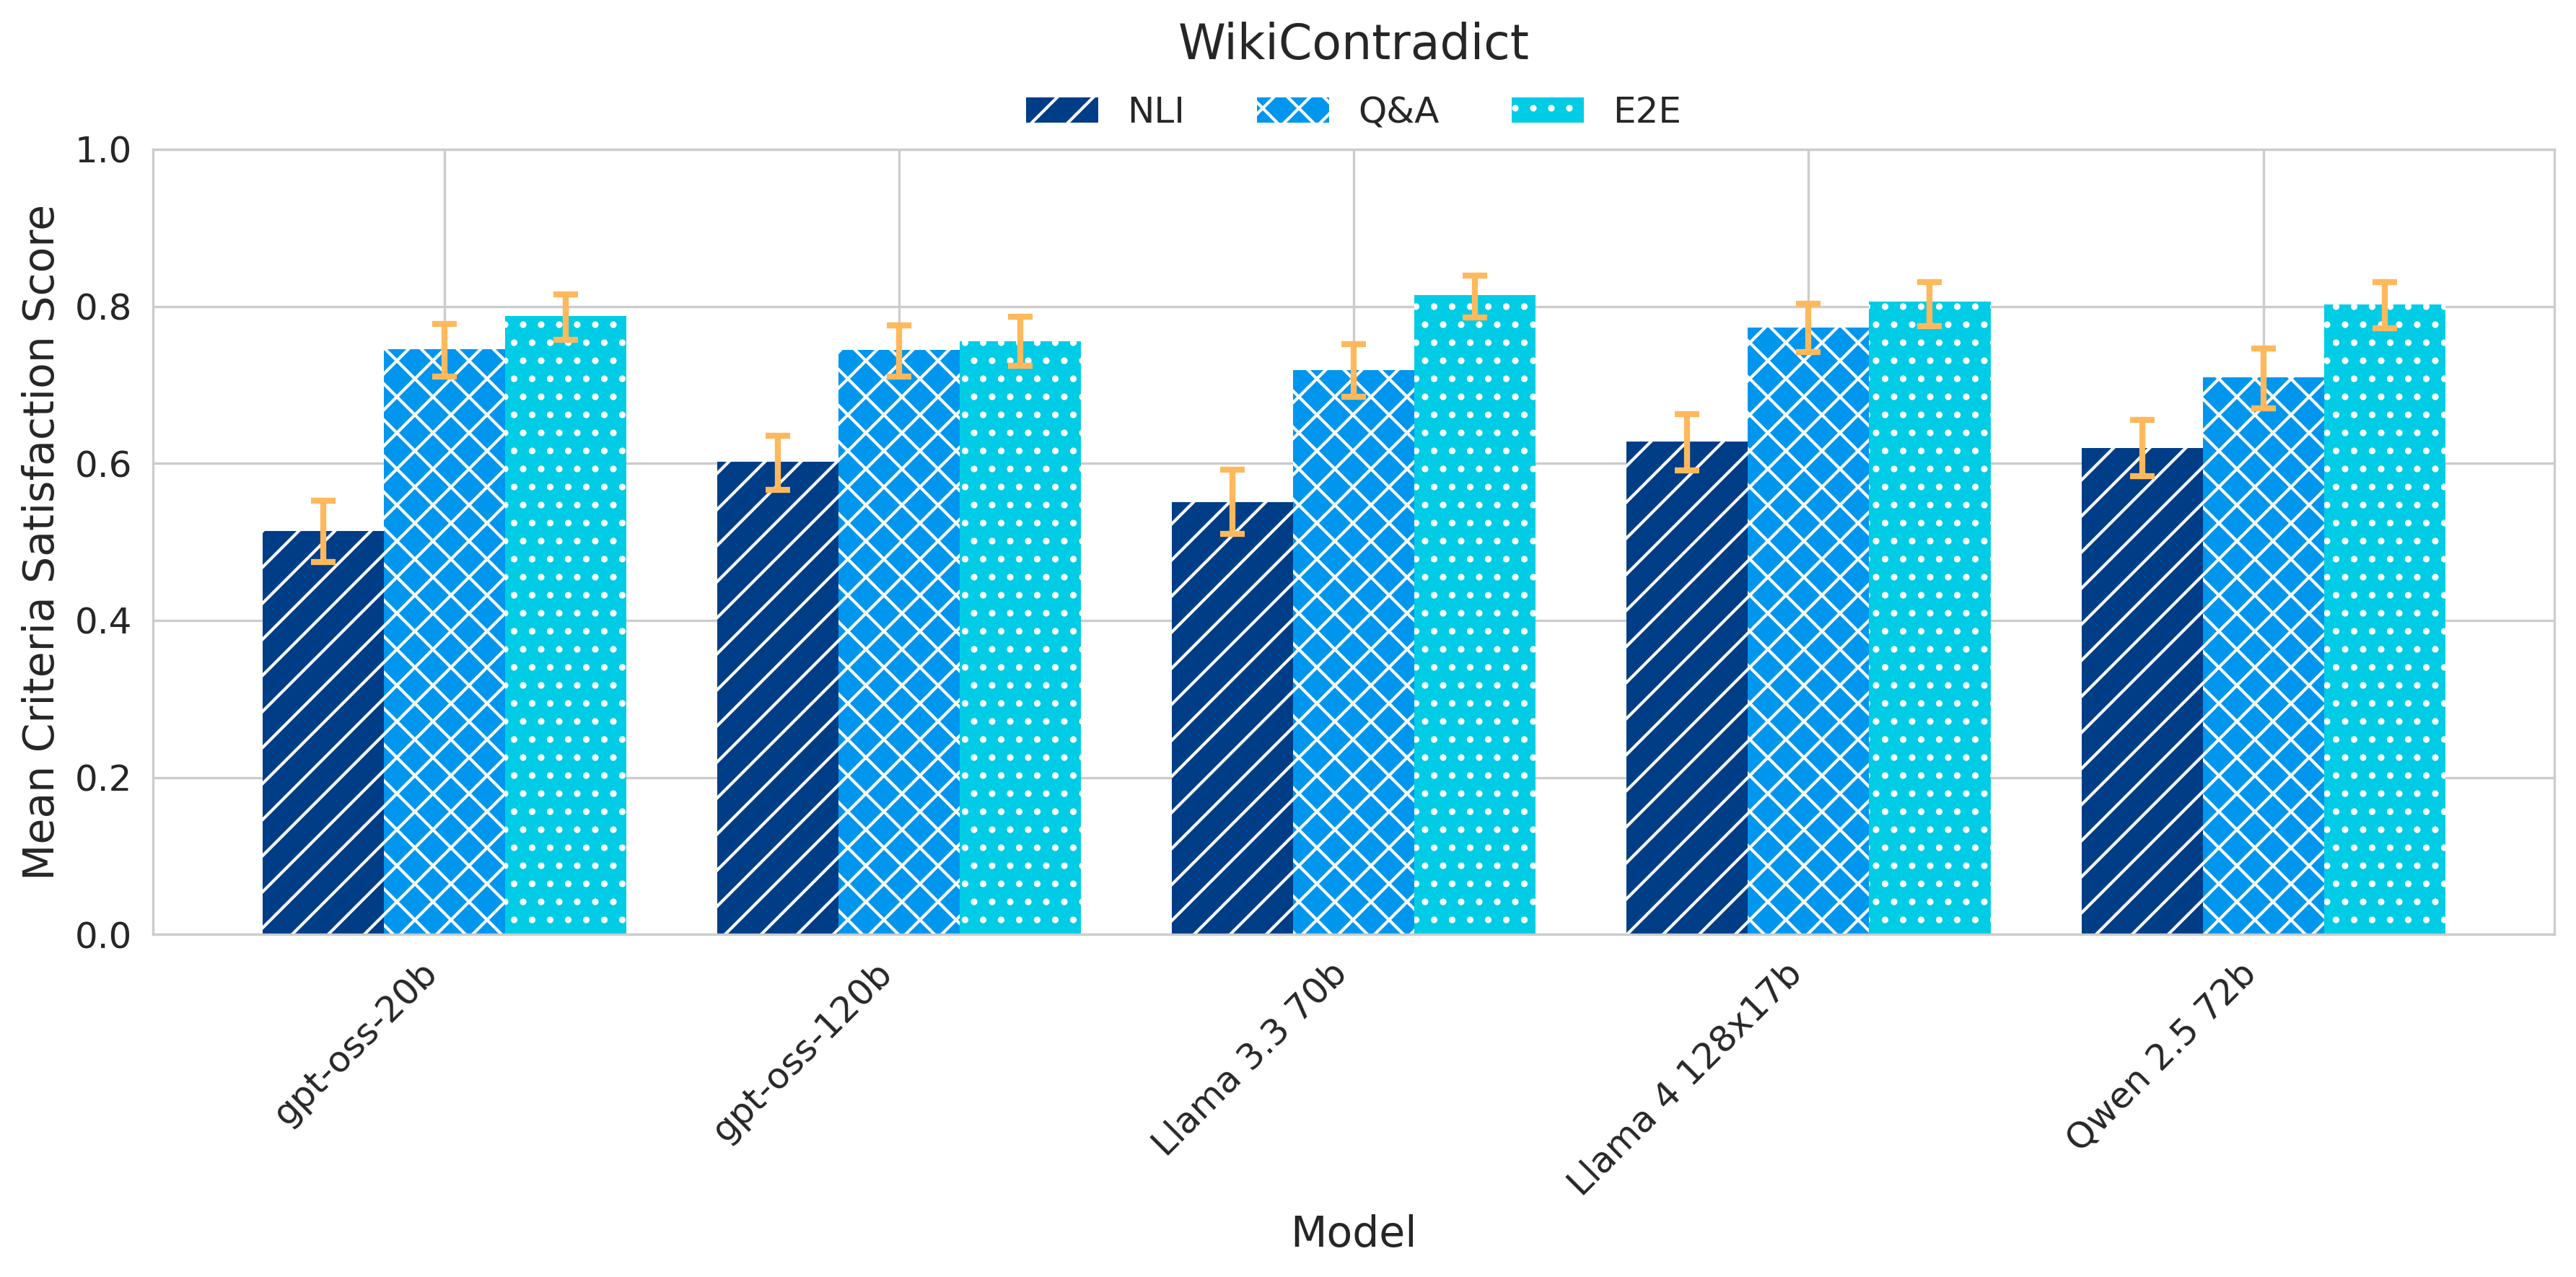

In [6]:
plot_config_results(
    df,
    configs=[
        {"variant": "nli"},
        {"variant": "qa", "use_tools": False},
        {"variant": "qa", "use_tools": True},
        {"variant": "e2e"},
    ],
    metric_name="WikiContradict Base",
    model_name_map={
        "gpt-oss-20b": "gpt-oss-20b",
        "gpt-oss-120b": "gpt-oss-120b",
        "llama-3.3-70b-instruct": "Llama 3.3 70b",
        "llama-4-maverick-17b-128e-instruct-fp8": "Llama 4 128x17b",
        "Qwen2.5-72B-Instruct": "Qwen 2.5 72b",
    },
    title="WikiContradict",
    ylabel="Mean Criteria Satisfaction Score",
    figsize=(12, 6),
)

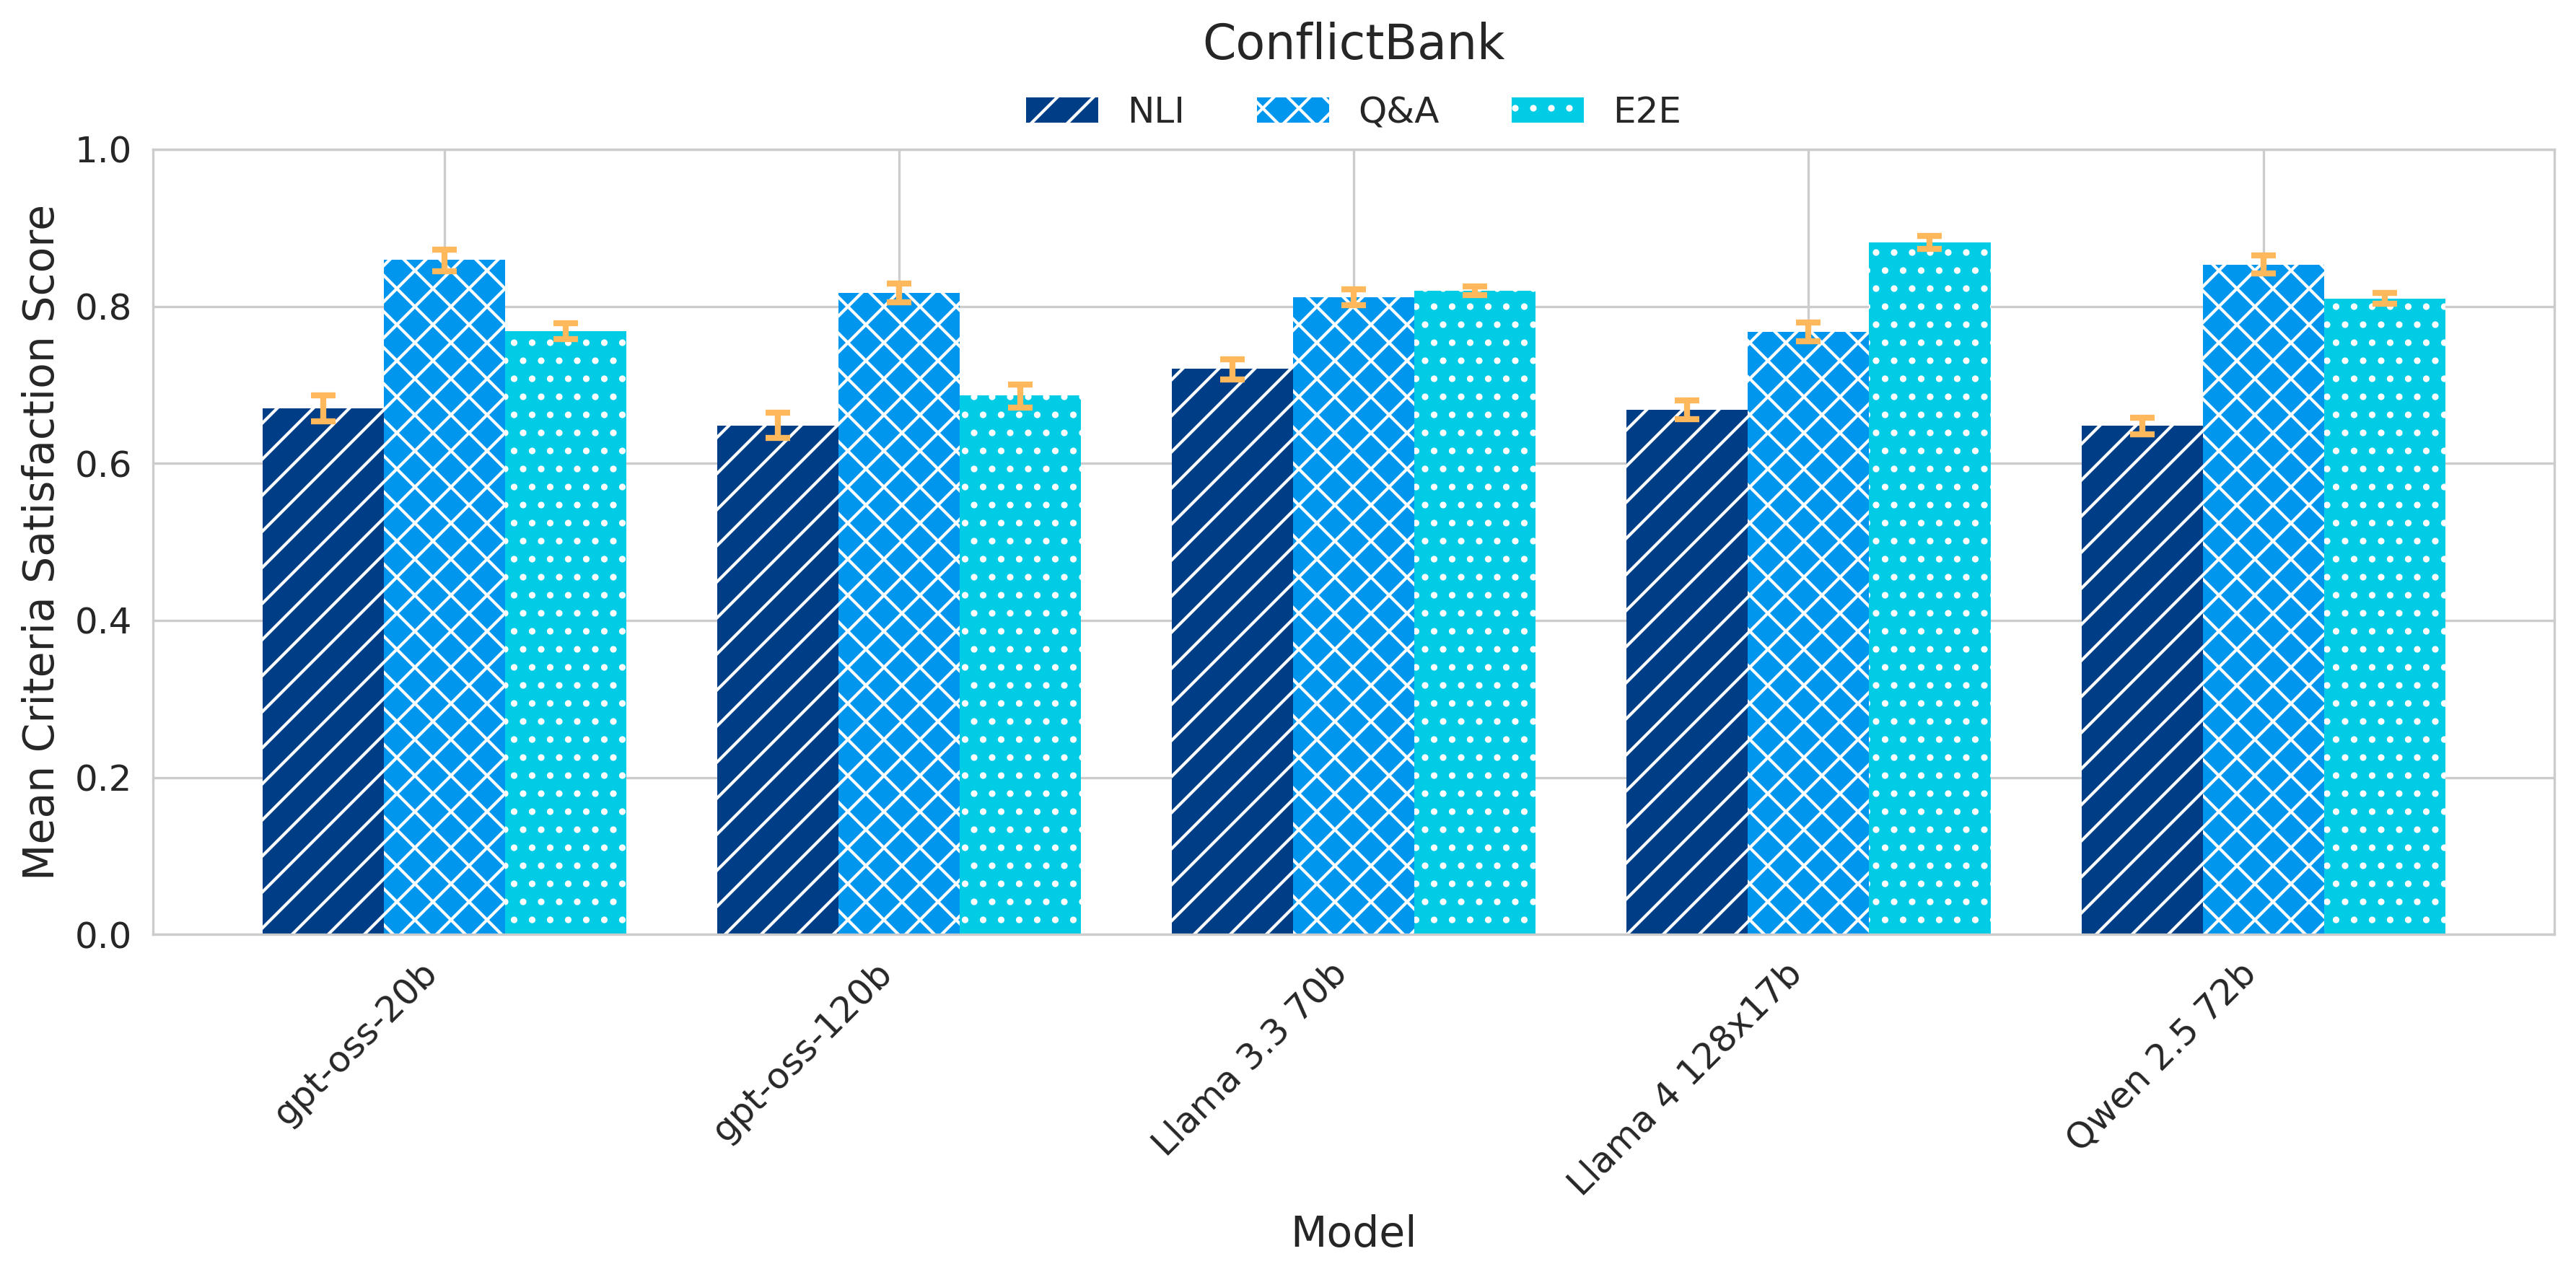

In [7]:
plot_config_results(
    df,
    configs=[
        {"variant": "nli"},
        {"variant": "qa", "use_tools": False},
        {"variant": "qa", "use_tools": True},
        {"variant": "e2e"},
    ],
    metric_name="ConflictBank Mean",
    model_name_map={
        "gpt-oss-20b": "gpt-oss-20b",
        "gpt-oss-120b": "gpt-oss-120b",
        "llama-3.3-70b-instruct": "Llama 3.3 70b",
        "llama-4-maverick-17b-128e-instruct-fp8": "Llama 4 128x17b",
        "Qwen2.5-72B-Instruct": "Qwen 2.5 72b",
    },
    title="ConflictBank",
    ylabel="Mean Criteria Satisfaction Score",
    figsize=(12, 6),
)

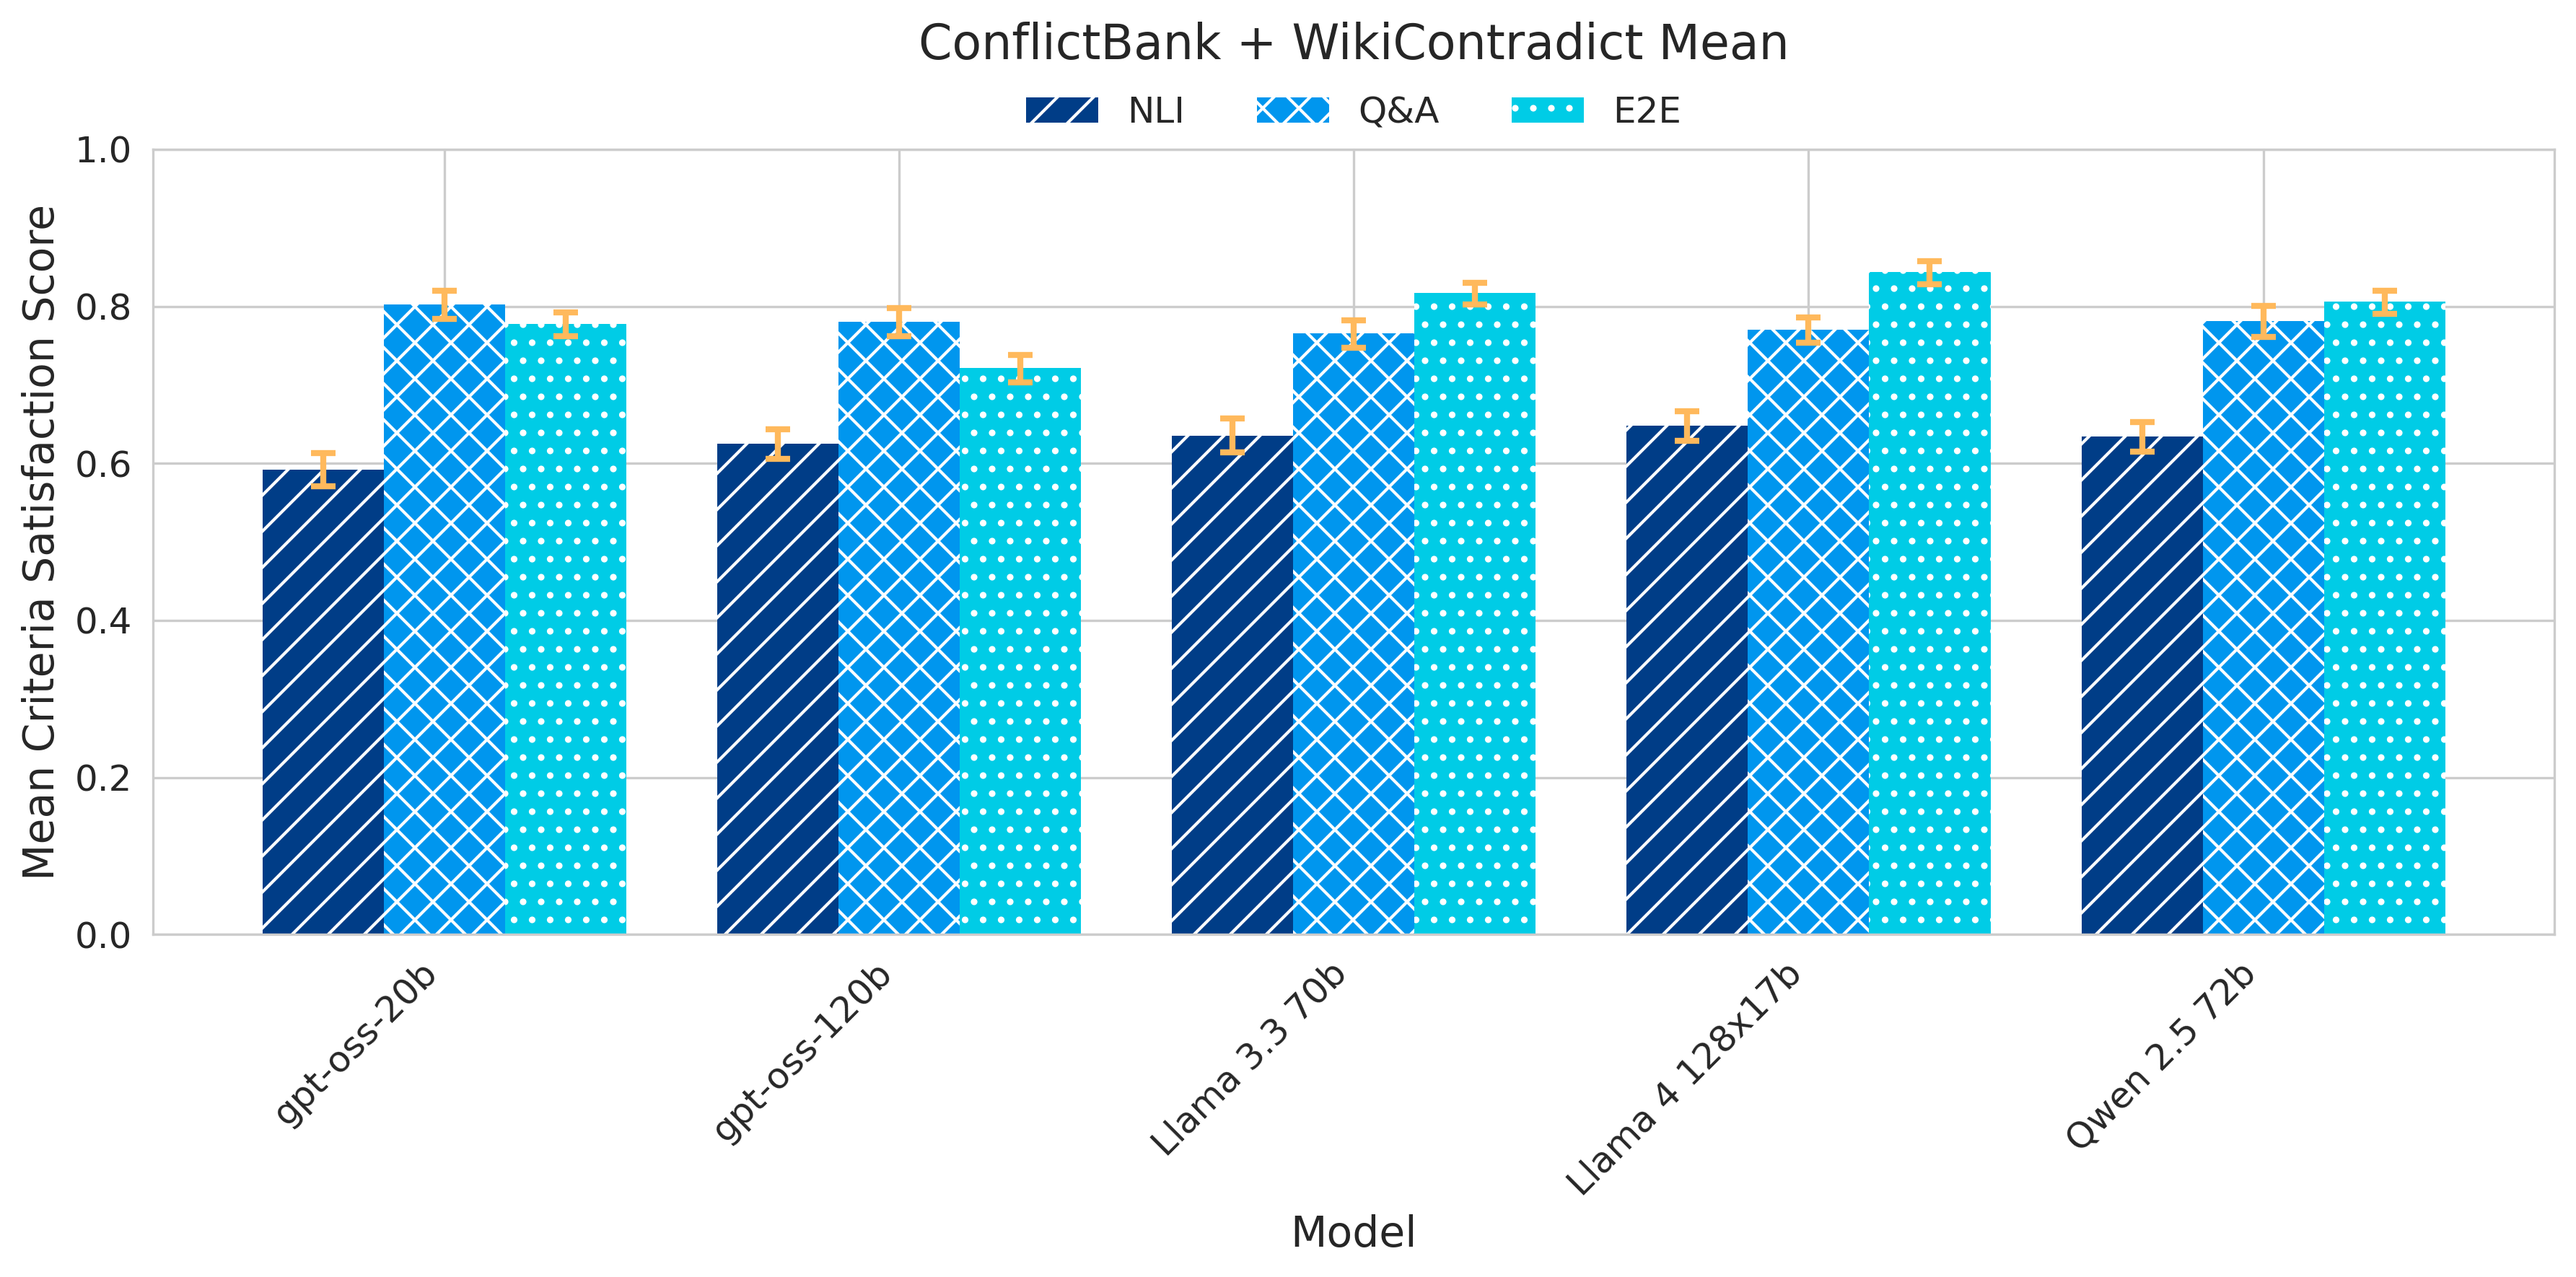

In [9]:
plot_config_results(
    df,
    configs=[
        {"variant": "nli"},
        {"variant": "qa", "use_tools": False},
        {"variant": "qa", "use_tools": True},
        {"variant": "e2e"},
    ],
    metric_name="Mean",
    model_name_map={
        "gpt-oss-20b": "gpt-oss-20b",
        "gpt-oss-120b": "gpt-oss-120b",
        "llama-3.3-70b-instruct": "Llama 3.3 70b",
        "llama-4-maverick-17b-128e-instruct-fp8": "Llama 4 128x17b",
        "Qwen2.5-72B-Instruct": "Qwen 2.5 72b",
    },
    title="ConflictBank + WikiContradict Mean",
    ylabel="Mean Criteria Satisfaction Score",
    figsize=(12, 6),
)

## ELI5


In [7]:
import pathlib

import pandas as pd


def display_eli5_results_for_version(version: str):
    load_dotenv()
    RESULTS_PATH = os.environ["RESULTS_PATH"]
    result_files = [p for p in pathlib.Path(RESULTS_PATH).iterdir() if p.is_file()]

    summary_results = []
    for result_file in result_files:
        if f"_{version}_" not in result_file.name:
            continue
        args, all_results = load_results(result_file.name)
        base_data = {
            "evaluated_model": args["evaluated_model_name"],
            "model": args["model_name"],
            "variant": args["variant"],
        }
        if args["dataset"] == "eli5_base":
            summary_results.append(
                {
                    **base_data,
                    "result": "ELI5 Base Comprehensiveness",
                    "value": compute_score_mean(all_results),
                }
            )
        elif args["dataset"] == "eli5_v2":
            summary_results.append(
                {
                    **base_data,
                    "result": "ELI5 V2 Comprehensiveness",
                    "value": compute_score_mean(all_results),
                }
            )

    df = pd.DataFrame(summary_results)
    df = (
        df.pivot(
            index=[
                "evaluated_model",
                "model",
                "variant",
            ],
            columns="result",
            values="value",
        )
        .reset_index()
        .sort_values(
            by=["evaluated_model", "model", "variant"], key=lambda col: col.str.lower()
        )
    )
    df["Comprehensiveness Mean"] = df[
        ["ELI5 Base Comprehensiveness", "ELI5 V2 Comprehensiveness"]
    ].mean(axis=1)
    df = df.reset_index(drop=True)

    with pd.option_context("display.precision", 2):
        display(df)

In [8]:
display_eli5_results_for_version("eval_ELI5_gpt-oss-20b")

result,evaluated_model,model,variant,ELI5 Base Comprehensiveness,ELI5 V2 Comprehensiveness,Comprehensiveness Mean
0,gpt-oss-120b,gpt-oss-20b,qa,0.60,0.71,0.65
1,gpt-oss-20b,gpt-oss-20b,qa,0.58,0.69,0.63
2,llama-3.3-70b-instruct,gpt-oss-20b,qa,0.52,0.67,0.59
3,llama-4-maverick-17b-128e-instruct-fp8,gpt-oss-20b,qa,0.54,0.67,0.60
4,Qwen2.5-72B-Instruct,gpt-oss-20b,qa,0.50,0.66,0.58


In [9]:
display_eli5_results_for_version("eval_ELI5_llama-4-maverick-17b-128e-instruct-fp8")

result,evaluated_model,model,variant,ELI5 Base Comprehensiveness,ELI5 V2 Comprehensiveness,Comprehensiveness Mean
0,gpt-oss-120b,llama-4-maverick-17b-128e-instruct-fp8,e2e,0.63,0.80,0.72
1,gpt-oss-20b,llama-4-maverick-17b-128e-instruct-fp8,e2e,0.59,0.77,0.68
2,llama-3.3-70b-instruct,llama-4-maverick-17b-128e-instruct-fp8,e2e,0.61,0.78,0.69
3,llama-4-maverick-17b-128e-instruct-fp8,llama-4-maverick-17b-128e-instruct-fp8,e2e,0.62,0.75,0.68
4,Qwen2.5-72B-Instruct,llama-4-maverick-17b-128e-instruct-fp8,e2e,0.52,0.71,0.61


In [11]:
display_eli5_results_for_version("eval_ELI5_llama-3-3-70b-instruct")

result,evaluated_model,model,variant,ELI5 Base Comprehensiveness,ELI5 V2 Comprehensiveness,Comprehensiveness Mean
0,gpt-oss-120b,llama-3.3-70b-instruct,e2e-base,0.47,0.69,0.58
1,gpt-oss-20b,llama-3.3-70b-instruct,e2e-base,0.45,0.64,0.54
2,llama-3.3-70b-instruct,llama-3.3-70b-instruct,e2e-base,0.50,0.68,0.59
3,llama-4-maverick-17b-128e-instruct-fp8,llama-3.3-70b-instruct,e2e-base,0.51,0.62,0.56
4,Qwen2.5-72B-Instruct,llama-3.3-70b-instruct,e2e-base,0.45,0.59,0.52
